## Setup

In [1]:
!pip install datasets
from datasets import Dataset, DatasetDict

import json
import re, os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import transformers
from collections import defaultdict
from tqdm import notebook as tqdm
from sklearn.model_selection import train_test_split

try:
    assert torch.cuda.is_available()
    device = torch.device("cuda")
except:
    device = torch.device("cpu")
print("Using device:", device)

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
!pip install unidecode
from unidecode import unidecode
import unicodedata
import re
import html

def normalize_text(text):
    text = html.unescape(text)
    text = unicodedata.normalize('NFKD', text)
    text = unidecode(text)
    text = re.sub(r"\s+", " ", text)
    return text

Using device: cuda
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 15.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder = f"/content/drive/MyDrive/DH"

# Load Bibles
bible = {}

to_remove = {}
items = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/overly_vague.csv").to_dict(orient='records')
for entry in items:
  if " - " not in entry['verse_id']: continue
  to_remove[entry['verse_id']] = None

b_versions = ['AKJV','ODRV','Geneva', 'Douay-Rheims', 'Tyndale', 'Wycliffe','Vulgate']
for bname in b_versions:
    data = pd.read_csv(f"{folder}/Bibles/{bname}.csv",header=None)
    data = data.to_dict(orient="records")
    for entry in tqdm.tqdm(data):
        key = entry[0]
        v_id = key.split(" (")[0]
        text = entry[6]
        if re.search("Douay-Rheims",key):
            if re.sub("Douay-Rheims","ODRV",key) in bible: continue
        if len(text.split(" ")) < 200:
            bible[key] = normalize_text(f"{v_id}: {text}")

        parts = re.split(r'(?<=[\.\?]) (?=[A-Z])|(?<=[\!\:\;])', text)
        parts = [re.sub(r'\s+', ' ', p).strip() for p in parts if len(p.strip(" ")) > 0]
        if (len(parts[0].split(" ")) <= 5 or len(parts[-1].split(" ")) <= 5 or re.search(r"\&\w+\;",parts[0])):
            for pidx, p in enumerate(parts): continue
        elif len(parts) > 1:
            for pidx, p in enumerate(parts):
              p_id = f"{key} - {pidx}"
              if p_id in to_remove: continue
              if len(p) == 0: continue
              if re.search(r"\&\w+\;",p) or len(p.split(" ")) <= 5: continue
              bible[p_id] = normalize_text(f"Part {pidx+1} of {v_id}: {p}")

bible['NonQP 0.0'] = "No Biblical quotation or paraphrase found"
bible_verses = list(bible.values())
bible_ids = list(bible.keys())
verse_to_id = {v:k for k,v in bible.items()}
bible_parts = {}
for key, text in bible.items():
  v_id = key.split(" - ")[0]
  if v_id not in bible_parts:
    bible_parts[v_id] = [v_id]
  if " - " not in key: continue
  bible_parts[v_id].append(key)

def get_parts(pos_id):
  parts = []
  if len(bible_parts[pos_id]) > 0:
      for part_id in bible_parts[pos_id]:
        parts.append(part_id)
  return parts

v_id_to_idx = {v_id:idx for idx, v_id in enumerate(bible_ids)}
bible_verses_no_prepend = [re.sub(r"^[\d\w\s]+\d+\.\d+\: |^Part \d+ of [\d\w\s]+\d+\.\d+\: ",'',v) for v in bible_verses]
bible["Genesis 1.2 (AKJV) - 0"], bible_verses_no_prepend[v_id_to_idx["Genesis 1.2 (AKJV) - 0"]]
len(bible_verses), len(bible_parts)

Mounted at /content/drive


  0%|          | 0/36702 [00:00<?, ?it/s]

  0%|          | 0/14737 [00:00<?, ?it/s]

  0%|          | 0/31090 [00:00<?, ?it/s]

  0%|          | 0/35811 [00:00<?, ?it/s]

  0%|          | 0/7954 [00:00<?, ?it/s]

  0%|          | 0/9622 [00:00<?, ?it/s]

  0%|          | 0/35809 [00:00<?, ?it/s]

(276171, 157011)

## Load Models and Bible Embeddings

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, models
from sentence_transformers.util import semantic_search, pytorch_cos_sim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/664.8 MB 83.4 MB/s eta 0:00:07

In [ ]:
model_checkpoint = "emanjavacas/MacBERTh"
model_name = "MacBERTh"

# model_checkpoint = "sentence-transformers/paraphrase-xlm-r-multilingual-v1"
# model_name = "SBERT-paraphrase-xlm-r-multilingual-v1"

# model_round = "R3" # "R1R2"
# checkpoint = "205" # "2028"
# model_name = f"EEPS_{model_round}_MacBERTh--checkpoint-{checkpoint}"
# model_checkpoint = f'{folder}/models/{"/".join(model_name.split("--"))}'

print(model_name, model_checkpoint)
if model_name == 'MacBERTh':
  word_embedding_model = models.Transformer(model_checkpoint, max_seq_length=128)
  pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), "mean")
  bi_encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])
else:
  bi_encoder = SentenceTransformer(model_checkpoint)

EEPS_files = set(os.listdir(f"{folder}/EEPS"))
if f"Bibles_{model_name}.pt" not in EEPS_files:
  bible_vectors = bi_encoder.encode(bible_verses, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
  torch.save(bible_vectors, f'{folder}/EEPS/Bibles_{model_name}.pt')
bible_vectors = torch.load(f'{folder}/EEPS/Bibles_{model_name}.pt',map_location=device)

if f"Bible_no_prepend_{model_name}.pt" not in EEPS_files:
  bible_vectors_no_prepend = bi_encoder.encode(bible_verses_no_prepend, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
  torch.save(bible_vectors_no_prepend,f"{folder}/EEPS/Bible_no_prepend_{model_name}.pt")
bible_vectors_no_prepend = torch.load(f"{folder}/EEPS/Bible_no_prepend_{model_name}.pt", map_location=device)

full_ids = [] # idx to orig idx
full_vectors = []
idx = 0
for orig_idx, v_id in enumerate(bible_ids):
  if " - " not in v_id: # a full verse
    full_ids.append(v_id)
    full_vectors.append(bible_vectors[orig_idx])
    idx += 1
print(len(full_ids),len(full_vectors))

# About


## Passages to Retrieve (Verses and subverses from different Bibles)##
I prepend verse ids (without version information) to the passages to increase the model's sensitivity to citation information in a given query. This approach assumes that the citation within a query sentence is accurate, which is not always true for my actual corpus of sermons because my segmentation procedure might attach a citation for a passage to the prior or succeeding passage. There may also be various quotations, with or without corresponding citations, in a single passage query. These are complexities that I must capture in my artifical training data. I construct training and development data from Biblical texts, but I ultimately test with a sample of true quotations/paraphrases from the sermons. When actually mining for quotations from sermons, I will postpend marginal notes that are relatively short and contain citations to each segmented sermon passage.

Significant partial verses are ones that are not overly vague (e.g., "Thus saith the Lord the God of Israel:"), have more than five words when tokenized by white space, and do not belong in a parent verse that begins or ends with a short phrase (five or fewer words long). This last condition is based on an assumption that the verses themselves do not usually contain more than two subverses; indeed, the average number of words demarcated by white spaces is only 23. The overly vague parts have been mined in advance, but there are still full verses that are overly vague.             

MacBERTh is uncased, but I retain casing for the passages for ease of reading. Because this retriever prioritizes semantic rather than lexical similarity, I normalize all unicode and HTML characters in the Biblical passages. Moreover, the TCP transcriptions do not include macrons for many words that should have omitted characters, e.g., "cofesse" instead of "cōfesse" for "confess". However, I do not correct or standardize any spellings. (Note: I do have regularized/standard spellings generated by MorphAdorner2.0 for my sermons corpus, but I will not use them for any purpose except as an additional feature in my CRF model for citation span identification).

Here is a mapping of ids to passages.
- Verse Format
  - "Reference x.y (Version)": "Reference x.y Text of verse"
  - 'Genesis 1.2 (AKJV)': 'Genesis 1.2: And the earth was without forme, and voyd, and darkenesse was vpon the face of the deepe: and the Spirit of God mooued vpon the face of the waters.'
- Subverse Format
  - "Reference x.y (Version) - 0": "Part 1 of Reference x.y Subverse text"
  - 'Genesis 1.2 (AKJV) - 0': 'Part 1 of Genesis 1.2: And the earth was without forme, and voyd, and darkenesse was vpon the face of the deepe:'

##Possible Query Types:##

*NOTE*: There may be variants for each query from each version: a variant may have a prepended or postpended verse or chapter citation (most common Bible book abbreviation/name + verse number without version information). The citation may only be the book abbrev/name with a verse or chapter number, or it may come after an additional phrase of "[Aa]s in".

- **FullVerse**: Full Bible verse. Positives should only be full Bible verses. Each parallel verse has the two chapter-only and no-citation variants; during training and evaluation, I will randomly pick one from these 3*N possibilities where N is the number of parallel verses for a verse from the AKJV (including the AKJV verse itself).
  - Parallel verses were mapped using [STEPBible.org's TVTMS data](https://github.com/STEPBible/STEPBible-Data/blob/master/TVTMS%20-%20Translators%20Versification%20Traditions%20with%20Methodology%20for%20Standardisation%20for%20Eng%2BHeb%2BLat%2BGrk%2BOthers%20-%20STEPBible.org%20CC%20BY.txt), which provides tests and versification correspondences for major scriptural traditions. I applied those individual tests to each applicable verse across the seven different Bibles used here.
- **Subverse**: A significant part of a Bible verse, i.e., a subverse that is not overly vague or short. The appended citations do not include subverse indices. I use a retriever fine-tuned with full verses with map parallel subverses. Positives should be their parent verses; I do not train with parallel subverses because those are relatively the same lengths as each other, hence symmetric. The FullVerse case already trains and evalutes symmetric retrieval.  There are five variants per subverse from each version of the Bible.
- **ProperNoun**: A proper noun referenced in that particular verse. During the preprocessing stage, I compile approximate spellings of that noun from each Bible version. These types of queries will help the model differentiate between different versions of the Bible. I also include the standard spelling as a query for each version. For nouns with a greater than average number of references, I sample multiple of these verses that are known cross references to append to the noun.
  - The dataset of proper nouns comes from [STEPBible.org's TINPR data](https://github.com/STEPBible/STEPBible-Data/blob/master/TIPNR%20-%20Translators%20Individualised%20Proper%20Names%20with%20all%20References%20-%20STEPBible.org%20CC%20BY.txt) ("Translators Individualised Proper Names with all References")
  - I use the difflib library's SequenceMatcher function with a similarity threshold of 0.7 and all unigrams to 5-grams. I also use MacBERTh to find semantic matches within the parallel verses of each reference. I only count the first lexical or semantic match of a noun for each reference of that noun.
- **Hybrid**: These are queries that include either the complete or partial verse of the Vulgate and the parallel text from the other English versions. There are many variants here with citations prepended or not, with the Latin preceding the English or vice versa, and with a full verse with a subverse or vice versa or both matching. All possible variants are included, and one is randomly sampled for each epoch of training. The appended citation is either from the Latin or English KJV versification tradition. These should have multiple positives per query (the English and the Latin verse).
- **CrossRef**: Cross references from [OpenBible](https://www.openbible.info/labs/cross-references/). I use a retriever fine-tuned with parallel verses in order to include cross references above a certain cosine similarity threshold as positives and those below another threshold as hard negatives. I will represent these in a graph as directed edges sized by their weights (similarity scores). These also have cited variants.
- **Combos**: These are queries that contain 2-3 short verses (either cross references or successive verses) with or without citations such that the query does not exceed the maximum sequence length for the tokenizer (512 tokens). These also include combinations of proper nouns with citations.
- **CitationOnly**: Full marginal notes that only contain citations without any quoted or paraphrased text. These will only have one query text, the note itself, and one positive passage (ID: NonQP 1.1, Passage: "No Biblical quotation or paraphrase found")


## Rounds of Training
I use MultipleNegativesRankingLoss, which uses in-batch negatives in addition to any hard negatives that I pass into the model. My batch size is 64. In order to avoid cross references being in the same batch, I use a greedy coloring algorithm and add all verse ids within batches that have a resulting size less than 64 to my development set. I reorder my training data so that they match their order across the batches when the batches are flattened into a single list. This ensures that when I disable shuffling when initializing a DataLoader instance, I can preserve these batches.

Notes on terminology: The **master verse id** is the key I use to organize all parallel verses. The set of master verse ids is equivalent to the ids of full verses in the AKJV Bible dataset without version info (e.g., the master id for "Genesis 1.1 (AKJV)" and "Genesis 1.1 (ODRV)" etc. is "Genesis 1.1"). I use the AKJV here because it is nearly identical to the English Standard Version, which OpenBible uses for its comprehensive cross references dataset.

**Accuracy** is defined as whether a model can correctly predict the similarity between a query and positive as greater than that between the query and a negative for triplets of (query/anchor, positive, negative).

**Recall @ k** (hereafter R@k) reflects the proportion of known positives that a model predicts for a query within its top k results. The metric I truly care for is R@200 because having a true positive within the top couple hundred retrieved results enables me to refine those results with a reranker (either another fine-tuned bi-encoder or a cross-encoder). I also care at R@6 because the average number of positives I labeled for each test example is 6.23.

**Fuzzy Precision @ k** (hereafter FP@k) is the proportion of the top k results that are either exact matches, parallel verses, or cross references of any of the known positives. I calculate "fuzzy" precision because I do not want my biases in my test set to interfere with my models' ability to predict more similar verses and Bible versions for sermon passages. I cannot promise that I labeled all the possible positives for a particular passage with Biblical citations, especially when I add in a larger set of labeled examples where I only did pairwise comparisons between passages and top predictions from the off-the-shelf MacBERTh model. For a "Golden Set" of just over a hundred passages, I did try to label and rank all possible matches from all versions, but that is not guaranteed to be perfect either. I care about FP@1 because this means that the top result is indeed direcly relevant to that known quotation or paraphrase. I examine FP@6 for the same reason as I do for R@6.
______________________________________





## 1. Symmetric Full Verse Retrieval, Round 1 (Success)
  - Pick a variant of a random positive for each master verse id. Let this be **query_id**.
  - For the positive of the query, randomly pick a positive such that it is not identical to **query_id** and is not from the same version as **query_id**. Moreover, if **query_id** is from a Protestant Bible (AKJV, Geneva, Tyndale), the positive should not be from another Protestant Bible. Instead, pick from a Catholic Bible unless there are none. Let this be **pos_id**.
  - Using base MacBERTh, mine full verses for all positives that are not positives or cross references of any of the positives. Each hard negative have less than 0.98 cosine similarity because MacBERTh similarity scores are all highly skewed towards the high end (see Table 1).
  - On the development set, this approach achieves a maximum of 0.9847 accuracy with two epochs of training. Accuracy begins to drop at the third epoch. Hence, I choose Checkpoint 1014 (=2 epochs) for my resulting model.
  - On the test set of real Biblical quotations/paraphrases from early sermons, this achieves a **0.455** R@200 and **0.412** FP@1. This performance is already much better than off-the-shelf MacBERTh's **0.396** R@200 and **0.36** FP@1. R@6 and FP@6 are roughly equivalent between these two models.

## 2. Asymmetric Retrieval: Subverse to Full Verse (Success)
  - I add subverses (with five variants each, see above) to the pools of queries and positives for each master verse id. I precompute 8 hard negatives for the raw text, i.e., text without any citations, of each verse and subverse because there is an average of 7.46 positives per master id.
  - For hard negative mining, I use the better model from the previous rounds. Checkpoint 1014 from Round 1 actually performs better on similarity scores than Checkpoint 2028 from Round 2 because the latter has been overfitted and is less generalizable to asymmetric retrieval. Moreover, the standard deviations are also slightly higher for Ckpt 2028, meaning that they are slightly less reliable (See Table 1). This also means that I should not train for more than 2 epochs on the same format of data, even if there is variation between the exact texts used per epoch.
  - The resulting model is Checkpoint 1521, which achieves a high of **0.727** on R@200 and **0.57** FP@1. For R@6 and FP@6, I also see significant improvement to 0.401 and 0.5 respectively. These are the best results I've seen so far for the test set across these rounds and the many that I've tried before I outlined my current approach. The average similarity for pairs of parallel verses and between subverses and their parent parallel verses are both the highest I've seen so far except for the undiscerning off-the-self model. Moreover, standard deviations for these similarity scores are also lower.

## 3. Asymmetric Retrieval: Hybrid English and Latin Passages with Multiple Positives Per Epoch

## Table 1 (μ ± σ)
| Comparison Type     |    MacBERTh             | R1 Checkpoint 1014  | R2 Checkpoint 2028 | R3 Checkpoint 1521  |
|-------------------------------------|-----------------|-----------------|-----------------|-----------------|
| Full parallel verses  | 0.92 ± 0.04     | 0.76 ± 0.16     | 0.71 ± 0.19     | 0.82 ± 0.13 |
| Subverses vs. parent verse & parent's parallels | 0.91 ± 0.05 |0.59 ± 0.19     | 0.53 ± 0.21     | 0.66 ± 0.14 |
| Cross references (From -> To) | 0.91 ± 0.04 |0.26 ± 0.17     | 0.24 ± 0.16     | 0.25 ± 0.17 |   

## Table 2 (Recall and Precision Scores)

# Different Types of Queries

## Datasets

### Load Essentials

In [ ]:
# top abbreviations or Bible names cited with a chapter or verse number within sermons
with open(f"{folder}/Bibles/top_abbrev.json") as file:
  abbrev = json.load(file)
new = {}
for a,b in abbrev.items():
  if a == b:
    new[a.capitalize()] = b.capitalize()
  else:
    new[a.capitalize()] = b.capitalize() + "."
abbrev = new
abbrev['Paralipomenon'] = "Paralip." # Reminder: mine citations without collapsing Chronicles & Paralipomenon
print(abbrev)

In [ ]:
with open(f"{folder}/EEPS/cross_references.json",'r') as file:
  CR = json.load(file)
len(CR)

In [ ]:
bible_parts = defaultdict(list)
for key in bible:
    if " - " not in key:
        continue
    v_id = key.split(" - ")[0]
    if not bible_parts[v_id]:
        bible_parts[v_id].append(v_id)
    bible_parts[v_id].append(key)
len(bible_parts)

In [ ]:
pattern = r'\b(' + '|'.join(re.escape(word) for word in abbrev) + r')\b'
def replace(match):
    return abbrev[match.group(0)]

def add_citation(text, q_id,chapter_only=False,verse_only=False,prepend_only=False,postpend_only = False):
    abbrev_id = re.sub(pattern, replace, q_id).split(" (")[0]
    chap_id = re.sub(pattern, replace, q_id.split(".")[0])
    text = text.strip(r"[.:;,?]")
    variants = []
    if not verse_only:
      if not prepend_only:
        variants.append("{}, {}".format(text, chap_id)) # Text, Ref. 1
        variants.append("{}, as in {}".format(text, chap_id)) # Text, as in Ref. 1.
      if not postpend_only:
        variants.append("{}, {}".format(chap_id, text)) # Ref. 1, Text
        variants.append("As in {}, {}".format(chap_id, text)) # As in Ref. 1, Text

    if not chapter_only:
      if not postpend_only:
        variants.append("{}, {}".format(abbrev_id, text)) # Ref. 1.1, Text
        variants.append("As in {}, {}".format(abbrev_id, text)) # As in Ref. 1.1., Text
      if not prepend_only:
        variants.append("{}, {}".format(text, abbrev_id)) # Text. Ref. 1.1
        variants.append("{}, as in {}".format(text, abbrev_id)) # Text, as in Ref. 1.1.
    return variants

add_citation("In the beginning God created the Heauen, and the Earth.", 'Genesis 1.1 (AKJV)')

### Parallel Verses

In [ ]:
def get_parallel_data():
    p_data = {}
    with open(f"{folder}/Bibles/PARALLEL_VERSES.json") as file:
      PV = json.load(file)

    for v_id, vlist in tqdm.tqdm(PV.items()):
      key = v_id.split(" (")[0]
      p_data[key] = { 'q_id': key,
                      'queries':{},
                      'pos':list(vlist),
                      'neg':[] # randomly sample one hard negative in addition to the in-batch negatives
                    }
      for q_id in vlist:
        for part_id in bible_parts.get(q_id, []):
          verse_text = bible_verses_no_prepend[v_id_to_idx[part_id]]
          p_data[key]['queries'][part_id] = add_citation(verse_text, part_id, False)
          p_data[key]['pos'].append(part_id)
        verse_text = bible_verses_no_prepend[v_id_to_idx[q_id]]
        p_data[key]['queries'][q_id] = add_citation(verse_text, q_id)
    return p_data

parallel = get_parallel_data()
len(parallel)

In [ ]:
PV = defaultdict(dict)
for master_id, item in parallel.items():
  for child_id in item['pos']:
    PV[child_id][master_id] = True

  # for idlist in item['queries'].values():
  #   for child_id in idlist:
  #     PV[child_id][master_id] = True
print(len(PV), PV['1 Kings 1.1 (Vulgate)'])

In [ ]:
parallel['2 Samuel 1.1']

In [ ]:
parallel['Susanna 1.1']

### Examine Cosine Similarity Scores

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def make_batches(data,batch_size=10000):
  data = [k for k in data]
  batches = []
  for start_index in range(0, len(data), batch_size):
    batch = data[start_index:start_index + batch_size]
    batches.append(batch)
  print(len(batches), 'batches')
  return batches

def get_sim_scores(data):
  vectors_1 = torch.stack([bible_vectors_no_prepend[v_id_to_idx[x]] for x,y in data])
  vectors_2 = torch.stack([bible_vectors_no_prepend[v_id_to_idx[y]] for x,y in data])
  vectors_1 = F.normalize(vectors_1, p=2, dim=1)
  vectors_2 = F.normalize(vectors_2, p=2, dim=1)
  vectors_1 = vectors_1.unsqueeze(1)
  vectors_2 = vectors_2.unsqueeze(2)
  sim_scores = torch.bmm(vectors_1, vectors_2)
  sim_scores = sim_scores.squeeze()
  sim_scores = sim_scores.tolist()
  return sim_scores

def plot_normal(data, xlabel='Cosine Similarity'):
  mean = np.mean(data)
  std = np.std(data)

  x = np.linspace(min(data), max(data), 100)
  pdf = norm.pdf(x, mean, std)
  plt.plot(x, pdf)
  plt.title(f'{model_name}\nMean={mean:.2f}, Std={std:.2f}')
  plt.xlabel(xlabel)
  plt.ylabel('Probability Density')
  plt.show()

def pv_sim(full=True):
  pv_scores = {}
  for _, item in tqdm.tqdm(sorted(parallel.items())):
    for q_id in item['pos']:
      if full and " - " in q_id: continue # full verse only
      if not full and " - " not in q_id: continue # subverse only
      for p_id in item['pos']:
        if " - " in p_id: continue # full verse only
        if q_id == p_id: continue
        if (p_id, q_id) in pv_scores: continue
        key = (q_id,p_id)
        pv_scores[key] = None
  print(len(pv_scores))

  pv_batches = make_batches(pv_scores)
  for batch in tqdm.tqdm(pv_batches):
    sim_scores = get_sim_scores(batch)
    for idx, score in enumerate(sim_scores):
      q_id, cr_id = batch[idx]
      pv_scores[(q_id, cr_id)] = score
  plot_normal(list(pv_scores.values()))

  0%|          | 0/36700 [00:00<?, ?it/s]

274196
28 batches


  0%|          | 0/28 [00:00<?, ?it/s]

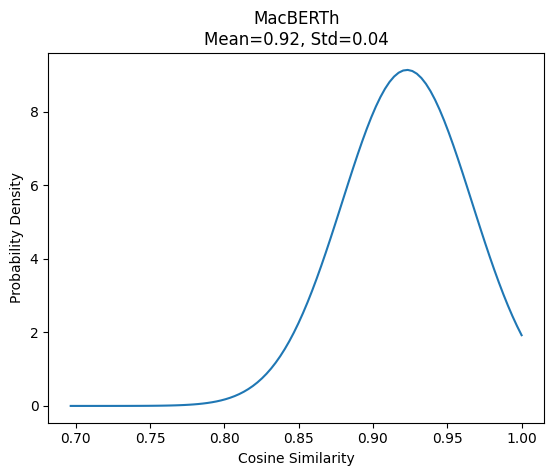

In [ ]:
pv_sim() # MacBERTh
# Mean=0.92, Std=0.04

  0%|          | 0/36700 [00:00<?, ?it/s]

527215
53 batches


  0%|          | 0/53 [00:00<?, ?it/s]

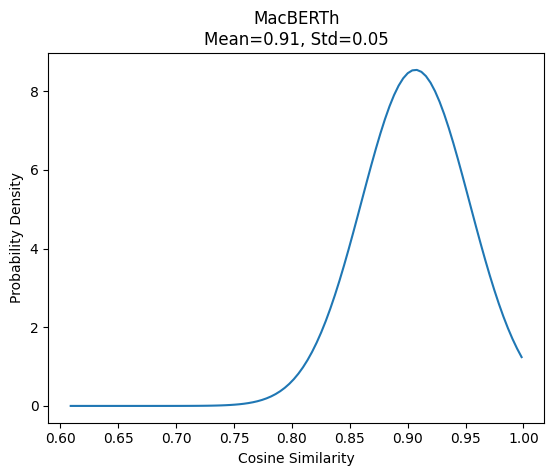

In [ ]:
print("Subverse to Full Verse")
pv_sim(False) # MacBERTh
# Mean=0.91, Std=0.05

  0%|          | 0/36700 [00:00<?, ?it/s]

274196
28 batches


  0%|          | 0/28 [00:00<?, ?it/s]

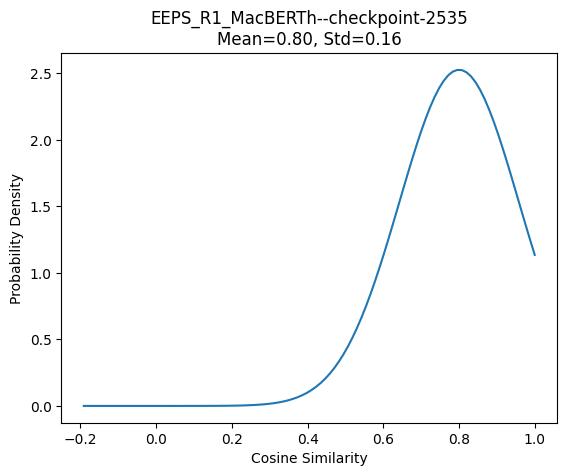

Subverse to Full Verse


  0%|          | 0/36700 [00:00<?, ?it/s]

527215
53 batches


  0%|          | 0/53 [00:00<?, ?it/s]

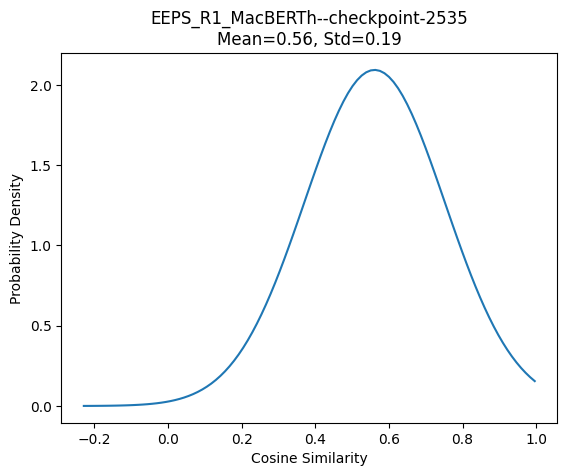

In [ ]:
pv_sim() # EEPS_R1_MacBERTh--checkpoint-2535
# Mean=0.80, Std=0.16
print("Subverse to Full Verse")
pv_sim(False)
# Mean=0.56, Std=0.19

  0%|          | 0/36700 [00:00<?, ?it/s]

274196
28 batches


  0%|          | 0/28 [00:00<?, ?it/s]

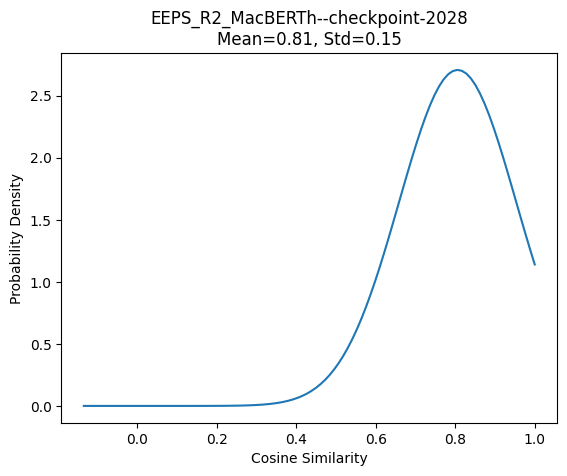

Subverse to Full Verse


  0%|          | 0/36700 [00:00<?, ?it/s]

527215
53 batches


  0%|          | 0/53 [00:00<?, ?it/s]

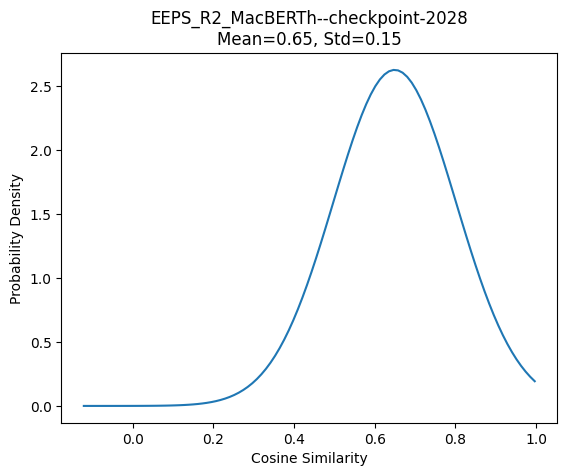

In [ ]:
pv_sim() # EEPS_R2_MacBERTh--checkpoint-2028
# Mean=0.81, Std=0.15
print("Subverse to Full Verse")
pv_sim(False)
# Mean=0.65, Std=0.15

  0%|          | 0/36700 [00:00<?, ?it/s]

274196
28 batches


  0%|          | 0/28 [00:00<?, ?it/s]

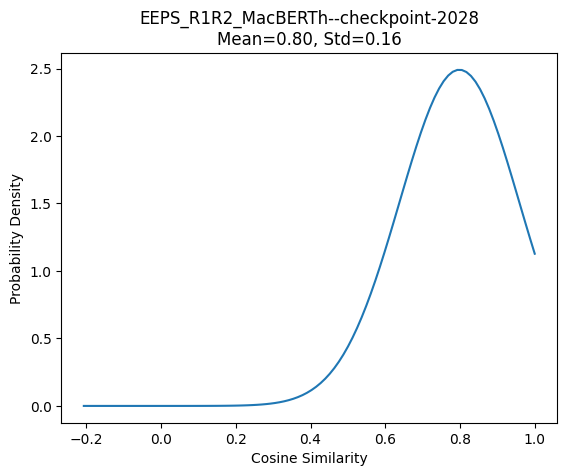

Subverse to Full Verse


  0%|          | 0/36700 [00:00<?, ?it/s]

527215
53 batches


  0%|          | 0/53 [00:00<?, ?it/s]

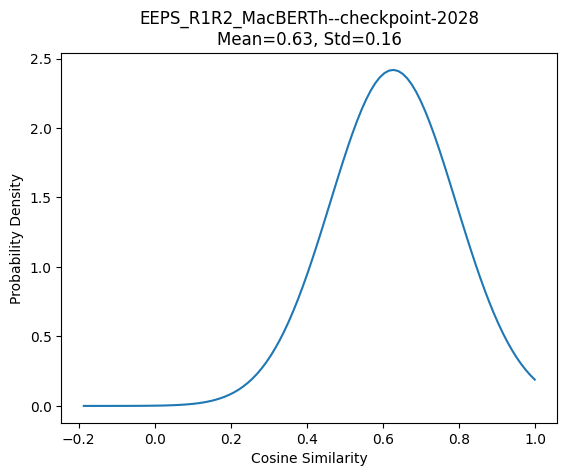

In [ ]:
pv_sim() # EEPS_R1R2_MacBERTh--checkpoint-2028
# Mean=0.80, Std=0.16
print("Subverse to Full Verse")
pv_sim(False)
# Mean=0.63, Std=0.16

In [ ]:
check_cr = {}
CR_actual = {}
for master_id, item in tqdm.tqdm(parallel.items()):
  if master_id not in CR: continue
  for q_id in item['pos']:
    if " - " in q_id: continue # full verse only
    q_ver = q_id.split(" (")[-1].strip(")")
    for cr in CR[master_id]:
      if cr in parallel:
        for cr_id in parallel[cr]['pos']:
          if " - " in cr_id: continue # full verse only
          key = (q_id,cr_id)

          # must be from the same version
          cr_ver = cr_id.split(" (")[-1].strip(")")
          if q_ver != cr_ver: continue

          if q_id not in CR_actual:
            CR_actual[q_id] = {}
          CR_actual[q_id][cr_id] = None

          if (cr_id, q_id) in check_cr: continue
          if key not in check_cr: check_cr[key] = []
          check_cr[key].append(master_id)

len(check_cr), len(CR_actual)

  0%|          | 0/36700 [00:00<?, ?it/s]

(2228933, 131797)

In [ ]:
list(CR_actual.items())[12]

('Genesis 5.31 (ODRV)',
 {'Genesis 10.32 (ODRV)': None,
  'Genesis 7.13 (ODRV)': None,
  'Genesis 9.18 (ODRV)': None,
  'Genesis 9.19 (ODRV)': None,
  'Genesis 10.1 (ODRV)': None,
  'Luke 3.36 (ODRV)': None,
  'Genesis 9.22 (ODRV)': None,
  'Genesis 9.23 (ODRV)': None,
  'Genesis 9.24 (ODRV)': None,
  'Genesis 9.25 (ODRV)': None,
  'Genesis 9.26 (ODRV)': None,
  'Genesis 9.27 (ODRV)': None,
  'Genesis 10.21 (ODRV)': None,
  'Genesis 6.10 (ODRV)': None})

In [ ]:
def cr_sim():
  check_cr_batches = make_batches(check_cr)
  CR_mapping = {}

  for batch in tqdm.tqdm(check_cr_batches):
    sim_scores = get_sim_scores(batch)
    for idx, score in enumerate(sim_scores):
      q_id, cr_id = batch[idx]
      # print(score)
      # print(q_id,bible_verses_no_prepend[v_id_to_idx[q_id]])
      # print(cr_id, bible_verses_no_prepend[v_id_to_idx[cr_id]])
      # print()
      CR_mapping[(q_id, cr_id)] = score
  plot_normal(list(CR_mapping.values()))

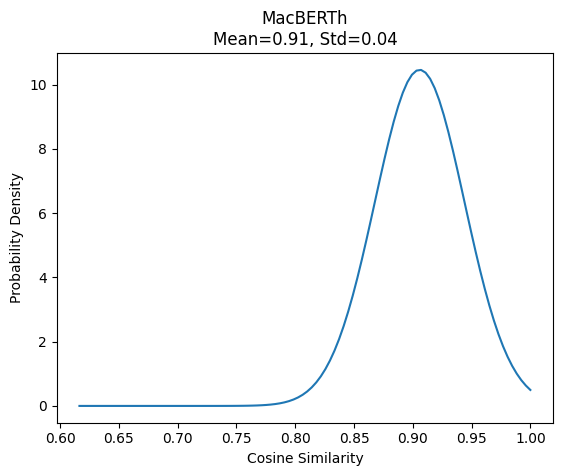

In [ ]:
cr_sim() # MacBERTh Mean=0.91, Std=0.04

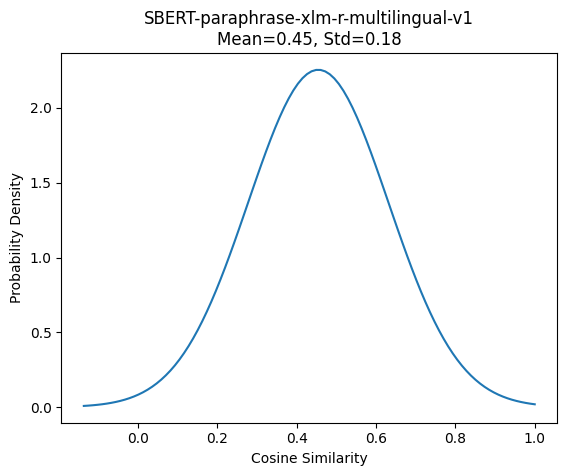

In [ ]:
cr_sim() # SBERT-paraphrase-xlm-r-multilinqual-v1
# Mean=0.45, Std=0.18

223 batches


  0%|          | 0/223 [00:00<?, ?it/s]

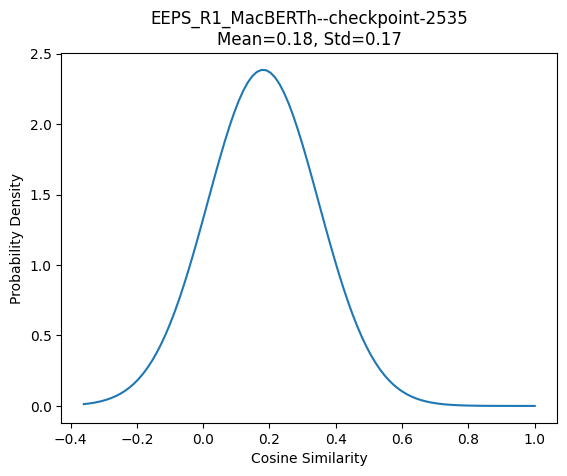

In [ ]:
cr_sim() # EEPS R1 MacBERTh--checkpoint-2535
# Mean=0.18, Std=0.17

223 batches


  0%|          | 0/223 [00:00<?, ?it/s]

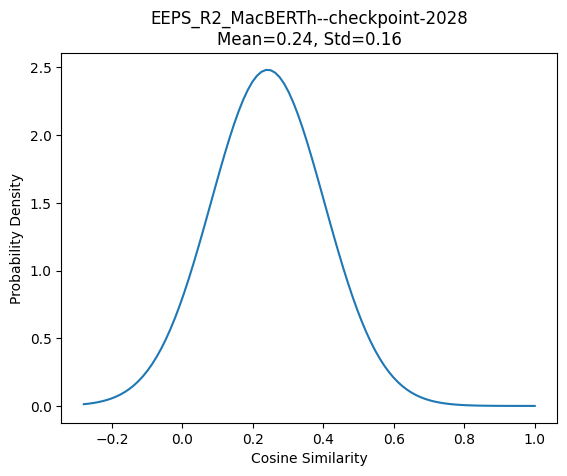

In [ ]:
cr_sim() # EEPS R2 MacBERTh--checkpoint-2028
# Mean=0.24, Std=0.16

223 batches


  0%|          | 0/223 [00:00<?, ?it/s]

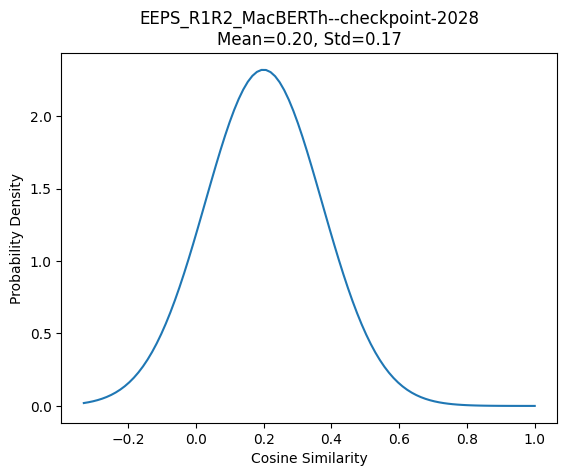

In [ ]:
cr_sim() # EEPS R1R2 MacBERTh--checkpoint-2028
# Mean=0.24, Std=0.16

In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json",'w+') as file:
  json.dump(CR_actual, file)

### Latin + English Hybrids


In [ ]:
def get_hybrid_data():
    p_data = {}
    with open(f"{folder}/Bibles/PARALLEL_VERSES.json") as file:
      PV = json.load(file)
    for v_id, vlist in tqdm.tqdm(PV.items()):
      key = v_id.split(" (")[0]
      p_data[key] = { 'q_id': key,
                      'queries':{'eng':{}, 'lat':{}}, # will only include the variants containing citations
                      'pos':[]
                      }
      for q_id in vlist:
        if 'Vul' in q_id:
          lang = 'lat'
          prepend_only = True
          postpend_only = False
        else:
          lang = "eng"
          prepend_only = False
          postpend_only = True
        for part_id in bible_parts.get(q_id, []):
          # add subverse
          verse_text = bible_verses_no_prepend[v_id_to_idx[part_id]]
          p_data[key]['queries'][lang][part_id] = add_citation(verse_text, part_id, False,prepend_only,postpend_only)
        # add full verse
        verse_text = bible_verses_no_prepend[v_id_to_idx[q_id]]
        p_data[key]['queries'][lang][q_id] = add_citation(verse_text, q_id,prepend_only,postpend_only)
        p_data[key]['pos'].append(q_id)
    return p_data

parallel = get_hybrid_data()
len(parallel), list(parallel.items())[0]

### Proper Nouns

In [ ]:
with open(f"{folder}/EEPS/PROPER_NOUN_TO_V_ID.json") as file:
  v_id_to_noun = json.load(file)
len(v_id_to_noun)

67213

In [ ]:
nounlist_to_id = {}
for v_id, nounlist in v_id_to_noun.items():
  if len(nounlist) == 1: continue # must have more than one individual word
  nounlist = ", ".join(nounlist)
  if nounlist not in nounlist_to_id:
    nounlist_to_id[nounlist] = {}
  for id in PV[v_id]:
    nounlist_to_id[nounlist][id] = True

subverse_nouns = {}
for v_id, nounlist in v_id_to_noun.items():
  for part_id in bible_parts.get(v_id,[]):
    if part_id == v_id: continue
    part_nouns = []
    for noun in nounlist:
      if noun.lower() in bible_verses_no_prepend[v_id_to_idx[part_id]].lower():
        part_nouns.append(noun)
    if len(part_nouns) > 0:
      subverse_nouns[part_id] = part_nouns
v_id_to_noun.update(subverse_nouns)

len(nounlist_to_id), len(v_id_to_noun), list(nounlist_to_id.items())[0]

(56138,
 108632,
 ('Of egypt, Torrent of egypt, Entrance of emath, Solomon, Israel, Emath, Egypt',
  {'2 Chronicles 7.8': True}))

In [ ]:
nouns_dataset = {}
for v_id, nounlist in v_id_to_noun.items():
  keys = PV[v_id]
  for key in keys:
    entry = parallel[key]
    if 'nouns' not in entry:
      entry['nouns'] = {}
    nounlist = ", ".join(nounlist)
    texts = add_citation(nounlist,v_id,verse_only=True)
    entry['nouns'][v_id] = texts
    nouns_dataset[key] = entry

In [ ]:
list(nouns_dataset.values())[12]['nouns']

{'Deuteronomy 7.15 (Geneva)': ['Moreouer, Lord, Egypt'],
 'Deuteronomy 7.15 (Wycliffe)': ['Lord, Egipt'],
 'Deuteronomy 7.15 (Douay-Rheims)': ['Lord, Egypt'],
 'Deuteronomy 7.15 (Vulgate)': ['Auferet, Dominus, AEgypti'],
 'Deuteronomy 7.15 (AKJV)': ['Lord, Egypt'],
 'Deuteronomy 7.15 (Wycliffe) - 0': ['Lord'],
 'Deuteronomy 7.15 (Wycliffe) - 1': ['Egipt'],
 'Deuteronomy 7.15 (Douay-Rheims) - 0': ['Lord'],
 'Deuteronomy 7.15 (Douay-Rheims) - 1': ['Egypt'],
 'Deuteronomy 7.15 (Vulgate) - 0': ['Auferet, Dominus'],
 'Deuteronomy 7.15 (Vulgate) - 1': ['AEgypti'],
 'Deuteronomy 7.15 (AKJV) - 0': ['Lord, Egypt']}

### Split & Sample

In [ ]:
from sklearn.model_selection import train_test_split
import random
random.seed(42)

def split_training_data(training_data,test_size):
    keys = list(training_data.keys())
    train_keys, dev_keys = train_test_split(keys, test_size=test_size, random_state=42)
    train_data = {k:training_data[k] for k in train_keys}
    dev_data = {k:training_data[k] for k in dev_keys}
    print(len(train_data),len(dev_data))
    return train_data, dev_data

# training_data = parallel
test_size=0.1
training_data = nouns_dataset
train_data, dev_data = split_training_data(training_data,test_size)

13541 1505


In [ ]:
# plot_normal([len(vlist['pos']) for vlist in training_data.values()],'Number of positives')

### Create Batches

In [ ]:
from collections import defaultdict
'''
Custom batching function so that no cross references are in the same batch
'''
def symmetrize_cross_refs(cross_refs_dict):
    symmetric_refs = defaultdict(set)
    for verse_id, refs in cross_refs_dict.items():
        for ref in refs:
            symmetric_refs[verse_id].add(ref)
            symmetric_refs[ref].add(verse_id)
    return {k: sorted(v) for k, v in symmetric_refs.items()}

def build_conflict_graph(cross_refs_dict):
  # from each verse to its cross refs (or vice versa, since the CR dict has been symmetrized)
  graph = defaultdict(set)
  for node, neighbors in cross_refs_dict.items():
    for neighbor in neighbors:
      graph[node].add(neighbor)
      graph[neighbor].add(node)
  return graph

def greedy_graph_coloring(graph):
  color_map = {}
  for node in sorted(graph, key=lambda x: len(graph[x]), reverse=True):
    neighbor_colors = {color_map[n] for n in graph[node] if n in color_map}
    for color in range(len(graph)):
      if color not in neighbor_colors:
        color_map[node] = color
        break
  return color_map

def group_by_color(color_map):
  grouped = defaultdict(list)
  for node, color in color_map.items():
    grouped[color].append(node)
  return list(grouped.values())

def chunk_batches(batches, chunk_size=64):
  final_batches = []
  for group in batches:
    for i in range(0, len(group), chunk_size):
      final_batches.append(group[i:i + chunk_size])
  return final_batches

def check_batches(batches):
  nope = []
  for i, batch in enumerate(batches):
    batch_set = set(batch)
    for verse in batch:
      cross_refs = CR.get(verse, [])
      for ref in cross_refs:
        if ref in batch_set and verse != ref:
          pair = tuple(sorted((verse, ref)))
          if pair not in nope:
            nope.append(pair)
  if len(nope) == 0: return True
  return False

def batch_queries(query_dict, cross_refs_dict, batch_size=64):
  cross_refs_dict = symmetrize_cross_refs(cross_refs_dict)
  graph = build_conflict_graph(cross_refs_dict)

  # Ensure all query_dict keys are in the graph, even if they have no cross refs
  for k in query_dict:
    graph.setdefault(k, set())

  color_map = greedy_graph_coloring(graph)
  groups = group_by_color(color_map)
  batches = chunk_batches(groups, batch_size)
  if check_batches(batches):
    return batches
  return None

CR_train = {}
for v_id, refs in CR.items():
  if v_id in train_data:
    CR_train[v_id] = []
    for r in refs:
      if r in train_data:
        CR_train[v_id].append(r)

train_batches = batch_queries(train_data, CR_train, batch_size=64)
print(train_batches[0])

['Genesis 35.22', 'Isaiah 1.1', 'Acts 7.36', 'Numbers 1.47', 'Acts 4.27', 'Jeremiah 1.3', '2 Chronicles 8.14', 'Luke 24.44', 'Genesis 15.18', 'Hebrews 11.32', 'Jeremiah 50.17', 'Ezekiel 25.15', 'Ruth 4.11', 'Genesis 19.37', 'Isaiah 11.11', 'Jeremiah 25.21', 'Nehemiah 7.6', 'Ezekiel 20.36', 'Acts 1.13', 'Matthew 1.9', 'Nehemiah 9.32', 'Isaiah 9.7', '2 Corinthians 11.26', 'Matthew 1.8', 'Genesis 19.38', 'Genesis 14.7', 'Joshua 10.40', 'Ezekiel 29.2', 'Hebrews 12.2', 'Ezra 7.7', 'Psalms 87.3', '1 Kings 1.8', 'Matthew 1.2', 'Jeremiah 23.6', 'Psalms 105.26', 'Obadiah 1.19', 'Nehemiah 10.18', 'Acts 26.18', 'Jude 1.11', 'Ecclesiastes 9.10', 'Joshua 14.4', 'Nehemiah 7.1', 'Colossians 2.16', 'Acts 26.20', 'John 1.17', 'Deuteronomy 9.7', 'Ezekiel 36.3', 'Jeremiah 30.18', 'Amos 2.4', '1 Chronicles 28.1', '1 Chronicles 13.2', 'Isaiah 23.1', 'Romans 1.7', 'Genesis 48.16', 'Acts 24.25', 'James 3.6', 'Matthew 3.7', 'Isaiah 13.4', 'Isaiah 8.10', 'Nehemiah 11.36', 'Numbers 1.16', '2 Kings 23.4', 'Hosea

In [ ]:
additional_dev = []
for i, batch in enumerate(train_batches):
  if len(batch) < 64:
    additional_dev.extend(batch)
for v_id in additional_dev:
  dev_data[v_id] = train_data[v_id]
additional_dev = set(additional_dev)
print(len(additional_dev))

final_train = {}
for i, batch in enumerate(train_batches):
  for v_id in batch:
    if v_id in additional_dev: continue
    final_train[v_id] = train_data[v_id]
print(len(final_train))
train_data = final_train

final_dev = {}
for key in dev_data:
  if key in train_data: continue
  final_dev[key] = dev_data[key]
dev_data = final_dev
len(dev_data)

421
13120


1926

### Negatives Mining Function

In [ ]:
NUM_NEGATIVES = 4

with open(f"{folder}/EEPS/CR_Actual.json") as file:
  CR_actual = json.load(file)

def is_PV(v_id, q_id):
  if " (" not in q_id:
    q_id = f"{q_id} (AKJV)"
  for id in PV[v_id]:
    if id in PV[q_id]:
      return True
  for id in PV[q_id]:
    if id in PV[v_id]:
      return True
  return False

def is_CR(v_id, q_id):
  if " (" not in q_id:
    q_id = f"{q_id} (AKJV)"
  if q_id in CR_actual:
    if v_id in CR_actual[q_id]:
      return True
      # if score >= 0.4: continue # for R2+
  if v_id in CR_actual:
    if q_id in CR_actual[v_id]:
      return True
      # if score >= 0.4: continue # for R2+
  return False

def get_negatives(vectors, ids, full_data = None, b_vectors = bible_vectors_no_prepend, noCR = True):
  NEGATIVES = {}
  hits = semantic_search(vectors,b_vectors,query_chunk_size=500,top_k=300)

  for idx, q_key in enumerate(ids):
    negs = []
    hitlist = hits[idx]
    if re.search("\w+ \d+\.\d+",q_key):
      q_id = q_key.split(" - ")[0]
    else:
      q_id = None

    for hit in hitlist:
      v_key = bible_ids[hit['corpus_id']]
      v_id = v_key.split(" - ")[0]
      score = float(hit['score'])
      # cannot be a parallel verse or a subverse of a parallel verse
      if q_id:
        if is_PV(v_id, q_id): continue
        if score >= 0.4 and noCR:
          if is_CR(v_id, q_id): continue
      else:
        if v_id in full_data[q_key]['pos'] or v_key in full_data[q_key]['pos']:
          continue
        for q_id in full_data[q_key]['pos']:
          q_id = q_id.split(" - ")[0]
          if is_PV(v_id, q_id): continue
          if score >= 0.4 and noCR:
            if is_CR(v_id, q_id): continue
      negs.append(v_key)
      if len(negs) == NUM_NEGATIVES: break

    if len(negs) < NUM_NEGATIVES:
      print("Not Enough Negatives")
      return None
    NEGATIVES[q_key] = negs
  return NEGATIVES

### Parallel Verse - Negatives

In [ ]:
bible_batches = make_batches(bible_ids, batch_size = 10000)
ALL_NEGATIVES = {}
for batch in tqdm.tqdm(bible_batches):
  vectors = []
  for id in batch:
    vectors.append(bible_vectors_no_prepend[v_id_to_idx[id]])
  ALL_NEGATIVES.update(get_negatives(vectors, batch))

with open(f"{folder}/EEPS/ALL_NEGATIVES_{model_name}.json",'w+') as file:
  json.dump(ALL_NEGATIVES, file)

### Proper Noun Sequences - Negatives

In [ ]:
ids, queries = [],[]
for v_id, nounlist in v_id_to_noun.items():
  text = ", ".join(nounlist)
  text = random.choice(add_citation(text, v_id))
  ids.append(v_id)
  queries.append(text)
len(ids), len(queries)

(108632, 108632)

In [ ]:
query_vectors = bi_encoder.encode(queries, batch_size=1024, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

In [ ]:
id_to_vec = {ids[idx]:vec for idx, vec in enumerate(query_vectors)}

In [ ]:
batches = make_batches(ids, batch_size = 10000)
ALL_NEGATIVES = {}
for batch in tqdm.tqdm(batches):
  vectors = []
  for id in batch:
    vectors.append(id_to_vec[id])
  ALL_NEGATIVES.update(get_negatives(vectors, batch, noCR=False))

with open(f"{folder}/EEPS/ALL_NEGATIVES_{model_name}.json",'w+') as file:
  json.dump(ALL_NEGATIVES, file)

11 batches


  0%|          | 0/11 [00:00<?, ?it/s]

# Training and Development Data (Triplets)

In [ ]:
from torch.utils.data import DataLoader,Dataset
from sentence_transformers import InputExample, LoggingHandler, SentenceTransformer, losses, models, util

import traceback
def check_dataset(data, data_dict):
  for i in range(len(data)):
    try:
      item = data[i]
    except Exception as e:
      key = list(data_dict.keys())[i]
      print(f"{key}: {data_dict[key]}")
      print("\nFull error traceback:")
      traceback.print_exc()
      break

### Parallel Verses

In [ ]:
class BibleDataset(Dataset):
  def __init__(self,data):
    self.queries = data
    self.queries_ids = list(data.keys())
    with open(f"{folder}/EEPS/ALL_NEGATIVES_{model_name}.json",'r') as file:
      self.negatives = json.load(file)
    for query in self.queries.values():
      random.shuffle(query["pos"])
      query_id = query['pos'].pop(0)
      query['pos'].append(query_id)
      query['query_id'] = query_id

  def __getitem__(self, item):
    query = self.queries[self.queries_ids[item]]

    query_id = query['query_id']
    query_text = random.choice(query['queries'][query_id])
    hasC = random.choice([0,1])
    if re.search("^Mark|^John|^Matthew|^Luke",query_id):
      hasC = True

    isPart = random.choice([0,1])
    firstPart = random.choice([0,1])
    if hasC:
      query_text = random.choice(query['queries'][query_id])
      if isPart:
        parts = query_text.split(",")
        if re.search(" \d+", parts[0]): # citation first
          c = parts[0]
          parts = parts[1:]
          if len(parts) > 1:
            if firstPart:
              # only want the first part if verse has more than one part
              query_text = c + "," + ",".join(parts[1:])
            else:
              # the last part in a multi-part verse
              query_text = c + "," + ",".join(parts[:-1])
        elif re.search(" \d+", parts[-1]):
          c = parts[-1]
          parts = parts[:-1]
          if len(parts) > 1:
            if firstPart:
              # only want the first part if verse has more than one part
              query_text = ",".join(parts[1:]) + "," + c
            else:
              # the last part in a multi-part verse
              query_text = ",".join(parts[:-1]) + "," + c
    else:
      query_text = bible_verses_no_prepend[v_id_to_idx[query_id]].strip(",") # without any metadata
      if isPart:
        parts = query_text.split(",")
        if len(parts) > 1:
          if firstPart:
            # only want the first part if verse has more than one part
            query_text = ",".join(parts[1:])
          else:
            # the last part in a multi-part verse
            query_text = ",".join(parts[:-1])

    pos_id = query["pos"].pop(0)
    query['pos'].append(pos_id)
    pos_text = bible[pos_id] # default in case the query id is the only positive
    query_version = query_id.split(" - ")[0].split(" (")[-1].strip(")")
    positives = [p for p in query['pos']]
    for pos_id in positives:
      pos_id = query["pos"].pop(0)
      query['pos'].append(pos_id)
      if pos_id == query_id: continue
      if " - " in pos_id: continue # positive cannot be a subverse
      pos_text = bible[pos_id]
      break

    # rotate through negs
    neg_id = self.negatives[query_id].pop(0)
    neg_text = bible[neg_id]
    self.negatives[query_id].append(neg_id)

    return InputExample(texts=[query_text, pos_text, neg_text])

  def __len__(self):
    return len(self.queries_ids)

### Hybrid Verse Triplets

In [ ]:
import random # no seed
class HybridDataset(Dataset):
  def __init__(self,data):
    self.queries = data
    self.queries_ids = list(data.keys())
    self.idx = 0 # add English positives in the second epoch
    for key, query in self.queries.items():
      # compile query text
      LC = random.choice([0,1])
      latlist = list(query['queries']['lat'].keys())
      englist = list(query['queries']['eng'].keys())
      if len(latlist) > 0:
        lat = random.choice(latlist)
        first_lang = 'lat'
      else:
        lat = random.choice(englist)
        first_lang = 'eng'
      eng = random.choice(englist)
      if len(bible_verses_no_prepend[v_id_to_idx[lat]].split()) <= 12:
        LC = 1
      if LC:
        lat_text = random.choice(query['queries'][first_lang][lat])
        eng_text = bible_verses_no_prepend[v_id_to_idx[eng]]
      else:
        lat_text = bible_verses_no_prepend[v_id_to_idx[lat]]
        EC = random.choice([0,1])
        if EC:
          eng_text = random.choice(query['queries']['eng'][eng])
        else:
          eng_text = bible_verses_no_prepend[v_id_to_idx[eng]]

      self.queries[key]['example'] = (lat_text, eng_text, lat, eng)

  def __getitem__(self, item):
    query = self.queries[self.queries_ids[item]]
    lat_text, eng_text, lat, eng = query['example']
    query_text = "{}. {}".format(lat_text, eng_text)

    # # add positive
    # if (self.idx / len(self.queries)) >= 1: # second epoch
    #   # add English
    #   pos_id = eng
    #   pos_text = eng_text
    # else:
    #   pos_id = lat
    #   pos_text = lat_text

    self.idx += 1

    return (query_text, (lat.split(" - ")[0],eng.split(" - ")[0]),self.queries_ids[item])

  def __len__(self):
    return len(self.queries_ids)

all_data = HybridDataset(training_data)
print(len(all_data))
check_dataset(all_data, training_data)

36700


#### Negatives

In [ ]:
queries = []
for i in range(len(all_data)):
  queries.append(all_data[i][0])
query_to_qid = {idx:id for idx, id in enumerate(training_data)}
query_to_vec = {idx:vec for idx, vec in enumerate(vectors)}

len(queries), len(query_to_qid), len(query_to_vec)

In [ ]:
vectors = bi_encoder.encode(queries,batch_size=1024, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
batches = make_batches(queries, batch_size = 10000)
ALL_NEGATIVES = {}
idx = 0
for batch in tqdm.tqdm(batches):
  batch_vec = []
  batch_ids = []
  for id in batch:
    batch_vec.append(query_to_vec[idx])
    batch_ids.append(query_to_qid[idx])
    idx += 1
  negs = get_negatives(batch_vec, batch_ids,b_vectors=bible_vectors)
  ALL_NEGATIVES.update(negs)

with open(f"{folder}/EEPS/ALL_NEGATIVES_{model_name}.json",'w+') as file:
  json.dump(ALL_NEGATIVES, file)

4 batches


  0%|          | 0/4 [00:00<?, ?it/s]

10000
10000
10000
6700


In [ ]:
len(ALL_NEGATIVES)

36700

#### Triplets

In [ ]:
hybrid_data = {}
for i in range(len(all_data)):
  item = all_data[i]
  hybrid_data[item[-1]] = (item[0], item[1])

for v_id, entry in train_data.items():
  pos = set(hybrid_data[v_id][1])
  entry['query_text'] = hybrid_data[v_id][0]
for v_id, entry in dev_data.items():
  pos = set(hybrid_data[v_id][1])
  entry['query_text'] = hybrid_data[v_id][0]

list(dev_data.items())[0]

('Genesis 19.8',
 {'q_id': 'Genesis 19.8',
  'queries': {'eng': {'Genesis 19.8 (AKJV)': ['Gen. 19, Behold now, I haue two daughters, which haue not knowen man; let mee, I pray you, bring them out vnto you, and doe ye to them, as is good in your eyes: onely vnto these men do nothing: for therefore came they vnder the shadow of my roofe',
     'As in Gen. 19, Behold now, I haue two daughters, which haue not knowen man; let mee, I pray you, bring them out vnto you, and doe ye to them, as is good in your eyes: onely vnto these men do nothing: for therefore came they vnder the shadow of my roofe'],
    'Genesis 19.8 (AKJV) - 0': ['Behold now, I haue two daughters, which haue not knowen man, Gen. 19',
     'Behold now, I haue two daughters, which haue not knowen man, as in Gen. 19'],
    'Genesis 19.8 (AKJV) - 1': ['let mee, I pray you, bring them out vnto you, and doe ye to them, as is good in your eyes, Gen. 19',
     'let mee, I pray you, bring them out vnto you, and doe ye to them, as is

In [ ]:
class BibleDataset(Dataset):
  def __init__(self,data):
    self.queries = data
    self.queries_ids = list(data.keys())
    with open(f"{folder}/EEPS/ALL_NEGATIVES_{model_name}.json",'r') as file:
      self.negatives = json.load(file)

  def __getitem__(self, item):
    query_id = self.queries_ids[item]
    query = self.queries[query_id]
    query_text = query['query_text']

    pos_id = query["pos"].pop(0)
    query['pos'].append(pos_id)
    pos_text = bible[pos_id]
    # the positive should not be the chosen segments
    positives = [p for p in query['pos']]
    for pos_id in positives:
      if 'Vulgate' in pos: continue
      pos_id = query["pos"].pop(0)
      query['pos'].append(pos_id)
      pos_text = bible[pos_id]
      break

    pos_text = bible[pos_id] # default in case the query id is the only positive

    # rotate through negs
    neg_id = self.negatives[query_id].pop(0)
    neg_text = bible[neg_id]
    self.negatives[query_id].append(neg_id)

    return InputExample(texts=[query_text, pos_text, neg_text])

  def __len__(self):
    return len(self.queries_ids)

### Proper Noun Sequence Triplets

In [ ]:
class BibleDataset(Dataset):
  def __init__(self,data):
    self.queries = data
    self.queries_ids = list(data.keys())
    with open(f"{folder}/EEPS/ALL_NEGATIVES_{model_name}.json",'r') as file:
      self.negatives = json.load(file)
    for query in self.queries.values():
      query['nounlist'] = list(query['nouns'].keys())
      random.shuffle(query["nounlist"])

  def __getitem__(self, item):
    query = self.queries[self.queries_ids[item]]

    query_id = query['nounlist'].pop(0)
    query['nounlist'].append(query_id)
    query_text = random.choice(query['nouns'][query_id])

    pos_id = query_id
    pos_text = bible[pos_id]

    # rotate through negs
    neg_id = self.negatives[query_id].pop(0)
    neg_text = bible[neg_id]
    self.negatives[query_id].append(neg_id)

    return InputExample(texts=[query_text, pos_text, neg_text])

  def __len__(self):
    return len(self.queries_ids)

### Initiate Evaluator

In [ ]:
eval_dataset = BibleDataset(dev_data)
print(len(eval_dataset))
check_dataset(eval_dataset, dev_data)

1926


In [ ]:
from sentence_transformers.evaluation import TripletEvaluator
# Triplet Evaluator: whether the sim score between the query & positive is greater than that of the query & negative
triplet_evaluator = TripletEvaluator.from_input_examples(eval_dataset, name='EEPS-triplets-dev',show_progress_bar=True, batch_size=1024)

for idx, item in enumerate(eval_dataset):
  print(item)
  print()
  if idx == 2:
    break

<InputExample> label: 0, texts: 4 King. 15.30, Osee, Ela, Phacee, Romelia; Part 1 of 4 Kings 15.30: Now Osee son of Ela conspired, and formed a plot against Phacee, the son of Romelia, and struck him, and slew him:; Genesis 36.41: Duke Aholibamah, duke Elah, duke Pinon,

<InputExample> label: 0, texts: Gen. 5.30, Lamech, Noe; Genesis 5.30: And Lamech liued, after he begat Noe, fiue hundred nintie fiue yeares, and begat sonnes and daughters.; 1 Chronicles 1.3: Henoch, Methushelah, Lamech,

<InputExample> label: 0, texts: Numb. 4.34, Recensuerunt, Moyses, Aaron, Caath; Numbers 4.34: Recensuerunt igitur Moyses et Aaron et principes synagogae filios Caath per cognationes et domos patrum suorum,; Part 1 of Leviticus 8.6: And anoon Moises offride Aaron and hise sones;



In [ ]:
results = triplet_evaluator(bi_encoder)
print(model_name)
results
# OTS MacBERTh for R1: {'EEPS-triplets-dev_cosine_accuracy': 0.38899341225624084}
# R1-2535 for R2: {'EEPS-triplets-dev_cosine_accuracy': 0.8560677170753479}

# OTS MacBERTh for Merged R1R2: {'EEPS-triplets-dev_cosine_accuracy': 0.3652398884296417}
# R1R2-2028 for R3: {'EEPS-triplets-dev_cosine_accuracy': 0.7455866932868958}

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

EEPS_R1R2_MacBERTh--checkpoint-2028


{'EEPS-triplets-dev_cosine_accuracy': 0.7455866932868958}

## Test Set as Triplets

In [ ]:
def fix_name(v_id):
  if "1 Kings" in v_id: v_id = "3 Kings" + v_id.split("1 Kings")[-1]
  elif "2 Kings" in v_id: v_id = "4 Kings" + v_id.split("2 Kings")[-1]
  elif "1 Samuel" in v_id: v_id = "1 Kings" + v_id.split("1 Samuel")[-1]
  elif "2 Samuel" in v_id: v_id = "2 Kings" + v_id.split("2 Samuel")[-1]
  elif re.search(r"^\d+ Chronicles",v_id): v_id = re.sub(r"Chronicles","Paralipomenon",v_id)
  return v_id

def get_test_dict():
    test_data = {}
    golden_set = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/GOLDEN_SET.csv").to_dict(orient='records')
    for item in golden_set:
      if "." not in str(item['verse_id']): # nonQP
        continue
      text = item['text'].strip()
      text = normalize_text(text)
      if text not in test_data: test_data[text] = {'query':text,
                                                'pos':[]}
      entry = test_data[text]
      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if item['label'] is False: continue
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)
        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id == "salms 44.18 (AKJV)": v_id = "Psalms 44.18 (AKJV)"
        if v_id in bible:
          entry['pos'].append(v_id)

    plus_set = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/GOLDEN_SET_additions.csv").to_dict(orient='records')
    for item in plus_set:
      text = item['text']
      if text not in test_data: test_data[text] = {'query':text,
                                                'pos':[]}
      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)
        entry = test_data[text]
        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          if item['correction'] is True or (item['correction'] is not False and item['prediction'] is True):
            entry['pos'].append(v_id)

    qp = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/preE_qp.csv")
    qp = qp[qp['label'] == True]
    more_qp = qp[qp['prediction'] == True].to_dict(orient='records')
    qp = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/preE_additions.csv")
    qp = qp[qp['prediction'] == True]
    qp = qp[qp['DS_prediction'] == True].to_dict(orient='records')
    more_qp.extend(qp)

    for item in more_qp:
      text = item['text']
      if text not in test_data: test_data[text] = {'query':text,
                                                'pos':[]}
      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)
        entry = test_data[text]
        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          entry['pos'].append(v_id)

    final_data = {}
    for id, item in test_data.items():
      if len(item['pos']) > 0:
        final_data[id] = item
    return final_data
test_data = get_test_dict()
print(len(test_data))

4215


In [ ]:
class TestDataset(Dataset):
  def __init__(self,data, negatives):
    self.queries = list(data.values())
    self.negatives = negatives
    for entry in self.queries:
      random.shuffle(entry["pos"])

  def __getitem__(self, item):
    query = self.queries[item]
    query_text = query['query']

    pos_id = query['pos'].pop(0)
    pos_text = bible[pos_id]
    query['pos'].append(pos_id)

    neg_id = self.negatives[query_text].pop(0)
    neg_text = bible[neg_id]
    self.negatives[query_text].append(neg_id)

    return InputExample(texts=[query_text, pos_text, neg_text])

  def __len__(self):
    return len(self.queries)

test_vectors = model.encode([entry['query'] for entry in test_data.values()], batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
test_negs = get_negatives(test_vectors, list(test_data.keys()), full_data =test_data)
test_dataset = TestDataset(test_data, test_negs)
print(len(test_dataset))
check_dataset(test_dataset, test_data)
test_evaluator = TripletEvaluator.from_input_examples(test_dataset, name='test',show_progress_bar=True, batch_size=1024)

# search = "the workes of our hands are sanctified by it, as Psal. 127."
# data = {search: {'pos': []}}
# test_vector = bi_encoder.encode([search], batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
# get_negatives(test_vector, [search], data)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

4215


In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R1_MacBERTh/checkpoint-2535")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8861209750175476}

In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R2_MacBERTh/checkpoint-2028")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8963226675987244}

In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R1R2_MacBERTh/checkpoint-1521")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8759193420410156}

In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R1R2T2_MacBERTh/checkpoint-2535")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8858837485313416}

In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R1R2T2_MacBERTh/checkpoint-2028")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8870700001716614}

In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R1R2T2_MacBERTh/checkpoint-1521")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8849347829818726}

In [ ]:
model = SentenceTransformer(f"{folder}/models/EEPS_R1R2T2_MacBERTh/checkpoint-3042")
results = test_evaluator(model)
del model
results

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

{'test_cosine_accuracy': 0.8844602704048157}

# Training

In [ ]:
from datetime import datetime
max_seq_length = 512
train_batch_size = 64
pooling = "mean"
lr = 2e-5

round_name = "R3"
model_save_path = "{}/models/{}".format(
    folder,
    f"EEPS_{round_name}_MacBERTh",
    # datetime.now().date()
)
print(model_save_path)

/content/drive/MyDrive/DH/models/EEPS_R3_MacBERTh


In [ ]:
train_dataset = BibleDataset(train_data)
print(len(train_dataset))
check_dataset(train_dataset, train_data)
train_dataloader = DataLoader(
  train_dataset,
  batch_size=64,
  shuffle=False
)
len(train_dataloader)

13120


205

In [ ]:
train_loss = losses.MultipleNegativesRankingLoss(model=bi_encoder)
num_epochs = 10 # monitor and do early stopping
print(len(train_dataloader.dataset), f"triplets per epoch")
total_training_steps = len(train_dataloader) * num_epochs
warmup_steps = 1000
print("Number of steps per epoch:", len(train_dataloader))

13120 triplets per epoch
Number of steps per epoch: 205


In [ ]:
import sys
sys.modules["wandb"] = None

In [ ]:
# Train the model
bi_encoder.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    use_amp=True,
    checkpoint_path=model_save_path,
    checkpoint_save_steps=len(train_dataloader),
    optimizer_params={"lr": lr},
    evaluator=triplet_evaluator,
)
'''
ROUND 1: Early Stopping - Checkpoint 2535
Step	Loss	      Cosine Accuracy
507	  0.916000		0.936500
1014	0.179200		0.957902
1521	0.101500		0.961900
2028	0.051400		0.963547
2535	0.028000		0.964252
3042	0.015500		0.963782

ROUND 2:
Step	Loss	      Cosine Accuracy
507	  0.683700		0.914393
1014	0.404800		0.924741
1521	0.257800		0.928034
2028	0.148000		0.930621
2535	0.094100		0.930151
3042	0.060900		0.930621

MERGED R1R2:
Step	Loss	      Cosine Accuracy
507	  1.109100		0.926858
1014	0.255400		0.943086
1521	0.144600		0.948495
2028	0.077100		0.949200
2535	0.044500		0.951552
3042	0.027600		0.952023
3549	0.019800		0.950611

ROUND 3:
Step	Loss	      Cosine Accuracy


'''

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Eeps-triplets-dev Cosine Accuracy
205,No log,No log,0.991173


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluation

## Load Test Data & Evaluate

In [ ]:
def fix_name(v_id):
  if "1 Kings" in v_id: v_id = "3 Kings" + v_id.split("1 Kings")[-1]
  elif "2 Kings" in v_id: v_id = "4 Kings" + v_id.split("2 Kings")[-1]
  elif "1 Samuel" in v_id: v_id = "1 Kings" + v_id.split("1 Samuel")[-1]
  elif "2 Samuel" in v_id: v_id = "2 Kings" + v_id.split("2 Samuel")[-1]
  elif re.search(r"^\d+ Chronicles",v_id): v_id = re.sub(r"Chronicles","Paralipomenon",v_id)
  return v_id

def get_test_data():
    test_set = {}
    golden_set = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/GOLDEN_SET.csv").to_dict(orient='records')
    output = []
    for item in golden_set:
      text = item['text'].strip()
      text = normalize_text(text)
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[], # verse ids with version
                                                'passages':[], # convert to list afterwards
                                                'positives':[]}
      entry = test_set[text]
      if "." not in str(item['verse_id']): # nonQP
        if bible_verses[-1] not in entry['passages']:
          entry['answers'].append(bible_ids[-1])
          entry['positives'].append(len(entry['passages'])-1)
          entry['passages'].append(bible_verses[-1])
          item['verse_text'] = bible_verses[-1]
          item['verse_id'] = bible_ids[-1]
          output.append(item)
        continue

      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if item['label'] is False: continue
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)

        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id == "salms 44.18 (AKJV)": v_id = "Psalms 44.18 (AKJV)"
        if v_id in bible:
          entry['passages'].append(bible[v_id])
        else:
          # print(v_id)
          continue

        entry['answers'].append(v_id)
        entry['positives'].append(len(entry['passages'])-1)
        output.append(item)

    plus_set = pd.read_csv(f"{folder}/Early-Modern-Sermons/assets/QP_Datasets/GOLDEN_SET_additions.csv").to_dict(orient='records')

    for item in plus_set:
      text = item['text']
      if text not in test_set: test_set[text] = {'question':text,
                                                'answers':[], # verse ids with version
                                                'passages':[], # convert to list afterwards
                                                'positives':[]}
      v_ids = item['verse_id'].split("; ")
      for v_id in v_ids:
        if re.search('Vulgate|Douay-Rheims|ODRV',v_id):
          v_id = fix_name(v_id)
        entry = test_set[text]

        if " - " in v_id:
          v_id = v_id.split(" - ")[0]
        if v_id in bible:
          entry['passages'].append(bible[v_id])
        else:
          # print(v_id)
          continue

        if item['correction'] is True or (item['correction'] is not False and item['prediction'] is True):
          entry['answers'].append(v_id)
          entry['positives'].append(len(entry['passages'])-1)

        output.append(item)

    test_data = []
    for entry in test_set.values():
      if "NonQP 0.0" in entry['answers']: continue
      if len(entry['answers']) == 0: continue

      entry['answers'] = {k:'' for k in entry['answers']}
      test_data.append(entry)
    len(test_data)

    return test_data
test_data = get_test_data()
print(len(test_data))

114


In [ ]:
with open(f"{folder}/EEPS/CR_Actual.json",'r') as file:
  CR = json.load(file)

def evaluate_semantic_search_SBERT(b_vectors, b_ids, vectors,data,k, verbose=False ):
  hits = semantic_search(vectors,b_vectors,query_chunk_size=1000,top_k=k)
  recalls_at_k = []
  precisions_at_k = []
  for idx, hitlist in enumerate(tqdm.tqdm(hits)):
    positives = []
    exact = []
    for rank, hit in enumerate(hitlist):
      if (rank+1) > k: break
      v_id = b_ids[hit['corpus_id']]

      key = v_id.split(" - ")[0]
      found = False
      for a_id in data[idx]['answers']:
        if a_id == key:
          found = True
          exact.append(key)
        if a_id in CR:
          if key in CR[a_id]:
            found = True
      if found: positives.append(key)
      if verbose and not found:
        if rank == 0:
          print("-" * 12)
          print(data[idx]['question'])
          print(data[idx]['answers'])
        print(v_id, hit['score'])
        print(bible[v_id])
    recalls_at_k.append(len(set(exact))/ len(data[idx]['answers']))
    precisions_at_k.append(len(positives) / k)

  recalls_at_k = round(sum(recalls_at_k)/len(recalls_at_k),3)
  precisions_at_k = round(sum(precisions_at_k)/len(precisions_at_k),3)
  # if recalls_at_k == 0 and precisions_at_k == 0:
  #   f1 = 0
  # else:
  #   f1 = round(2 * ((recalls_at_k*precisions_at_k) / (recalls_at_k + precisions_at_k)),3)
  # print(f"F1@{k}: {f1}")
  print(f"R@{k}: {recalls_at_k}")
  print(f"FP@{k}: {precisions_at_k}")

In [ ]:
test_vectors = bi_encoder.encode([entry['question'] for entry in test_data], batch_size=1024, convert_to_tensor=True, show_progress_bar=True)
sum([len(item['answers']) for item in test_data]) / len(test_data)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

6.2368421052631575

## Results

In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

EEPS_R3_MacBERTh--checkpoint-205


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.047
FP@1: 0.36


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.226
FP@6: 0.278


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.476
FP@200: 0.051


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

EEPS_R3_MacBERTh--checkpoint-2028


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.065
FP@1: 0.404


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.314
FP@6: 0.363


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.603
FP@200: 0.051


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

EEPS_R1R2_MacBERTh--checkpoint-2028


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.079
FP@1: 0.553


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.398
FP@6: 0.485


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.765
FP@200: 0.092


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

EEPS_R1R2_MacBERTh--checkpoint-1521


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.078
FP@1: 0.561


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.36
FP@6: 0.461


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.708
FP@200: 0.088


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

EEPS_R2_MacBERTh--checkpoint-2028


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.073
FP@1: 0.5


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.348
FP@6: 0.45


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.653
FP@200: 0.087


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

EEPS_R1_MacBERTh--checkpoint-2535


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.071
FP@1: 0.474


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.295
FP@6: 0.373


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.627
FP@200: 0.071


In [ ]:
print(model_name)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 1)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 6)
evaluate_semantic_search_SBERT(full_vectors, full_ids, test_vectors, test_data, 200)

MacBERTh


  0%|          | 0/114 [00:00<?, ?it/s]

R@1: 0.068
FP@1: 0.395


  0%|          | 0/114 [00:00<?, ?it/s]

R@6: 0.22
FP@6: 0.259


  0%|          | 0/114 [00:00<?, ?it/s]

R@200: 0.396
FP@200: 0.035


In [ ]:
from google.colab import runtime
runtime.unassign()